In [1]:
import sys
sys.path.append("..")

import torch
from diffusers import StableDiffusion3Pipeline

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

from utils.data import get_data
from transformers import TextStreamer

In [2]:
#load stable diffusion
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")
#load llava
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512

model_name = get_model_name_from_path(MODEL_NAME)
tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=True, load_4bit=False, device_map="auto")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_mod

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [3]:
def run_stable_diffusion(desc):
    image = pipe(
        desc,
        negative_prompt="",
        num_inference_steps=30,
        guidance_scale=7.0,
    ).images[0]
    return image

In [4]:
def run_llava(image, cap):
    if "llama-2" in model_name.lower():
        conv_mode = "llava_llama_2"
    elif "mistral" in model_name.lower():
        conv_mode = "mistral_instruct"
    elif "v1.6-34b" in model_name.lower():
        conv_mode = "chatml_direct"
    elif "v1" in model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"

    conv = conv_templates[conv_mode].copy()
    if "mpt" in model_name.lower():
        roles = ('user', 'assistant')
    else:
        roles = conv.roles

    image_size = image.size
    # Similar operation in model_worker.py
    image_tensor = process_images([image], image_processor, model.config)
    if type(image_tensor) is list:
        image_tensor = [image.to(model.device, dtype=torch.float16) for image in image_tensor]
    else:
        image_tensor = image_tensor.to(model.device, dtype=torch.float16)

    inp = """Provide a description of the image in one sentence and enclose it in  <desc></desc> tags. Make up a detailed caption for the given image to use in a news article in one sentence. Make up fake specific details such as name, place, time etc. to make the caption seem detailed and believable. Your caption should be close to this text: {}. Enclose the caption in <caption></caption> tags.""".format(cap)

    if image is not None:
        # first message
        if model.config.mm_use_im_start_end:
            inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
        else:
            inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
        image = None

    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    #streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            #streamer=streamer,
            use_cache=True)

    outputs = tokenizer.decode(output_ids[0]).strip()
    conv.messages[-1][-1] = outputs

    print("\n", {"prompt": prompt, "outputs": outputs}, "\n")
    output = {'desc':outputs[outputs.find('<desc>')+len('desc'):outputs.find('</desc>')], 'caption':outputs[outputs.find('<caption>')+len('<caption>'):outputs.find('</caption>')]}
    return output

In [5]:
image, caption, img_path, annotation = get_data(4)

In [6]:
output = run_llava(image)
desc, caption_ = output['desc'], output['caption']
image_ = run_stable_diffusion(desc)


 {'prompt': '<|im_start|>system\nAnswer the questions.<|im_end|><|im_start|>user\n<image>\nProvide a description of the image in one sentence. Add a description of the image in  <desc></desc> tags. Make up a caption for the given image to use in a news article in one sentence. Make up any details such as name, place, time etc. to make the caption seem real and believable. Enclose the caption in <caption></caption> tags.<|im_end|><|im_start|>assistant\n', 'outputs': 'The image shows a 3D rendering of a humanoid robot with a black and silver color scheme. The robot has a human-like form with a head, torso, arms, and legs. It features a complex design with visible mechanical parts and joints, suggesting advanced functionality and movement capabilities. The robot\'s head has a black dome with two blue lights, possibly representing eyes. On the torso, there is a visible logo or text that reads "THOR."\n\n<desc>A 3D model of a humanoid robot named THOR.</desc>\n\n<caption>Virginia Tech\'s l

  0%|          | 0/28 [00:00<?, ?it/s]

TRUE IMAGE: 


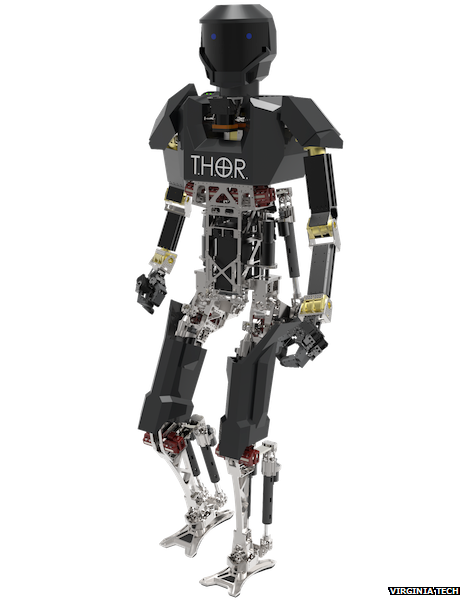

TRUE CAPTION:  Virginia Tech s Thor includes artificial elastic muscles It will not be ready until 2014 so will be replaced by a less advanced substitute at this stage
FALSE IMAGE: 


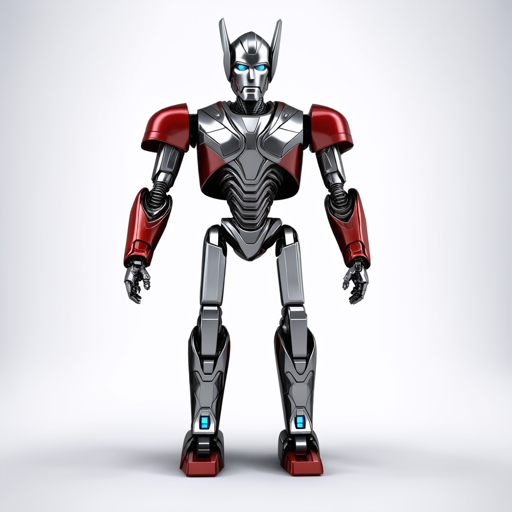

FALSE CAPTION:  Virginia Tech's latest humanoid robot, THOR, showcases advanced technology and design.


In [8]:
print("TRUE IMAGE: ")
display(image)
print("TRUE CAPTION: ", caption)
print("FALSE IMAGE: ")
image_ = image_.resize((512, 512))
display(image_)
print("FALSE CAPTION: ", caption_)

In [5]:
import gradio as gr
import os
import time
from PIL import Image
import numpy as np

def store_files(image, text):
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    os.makedirs("stored_outputs", exist_ok=True)
    
    # Save image
    image.save(f"stored_outputs/image_{timestamp}.png")
    
    # Save text
    with open(f"stored_outputs/text_{timestamp}.txt", "w") as f:
        f.write(text)
    
    return "Files stored successfully!"

def process_inputs(image, text):
    output = run_llava(image, text)
    desc, processed_text = output['desc'], output['caption']
    processed_image = run_stable_diffusion(desc)
    processed_image = processed_image.resize((512, 512))
    return processed_image, processed_text

# Gradio interface
demo = gr.Blocks()

with demo:
    gr.Markdown("# Synthetic Data Generator for Misinformation Detection Task")
    
    with gr.Row():
        image_input = gr.Image(type='pil')
        text_input = gr.Textbox(label="Input Text")
    
    process_btn = gr.Button("Process")
    
    with gr.Row():
        image_output = gr.Image(label="Generated Image", type='pil')
        text_output = gr.Textbox(label="Generated Text")
    
    store_btn = gr.Button("Store Outputs")
    store_output = gr.Textbox(label="Storage Status")
    
    process_btn.click(
        process_inputs,
        inputs=[image_input, text_input],
        outputs=[image_output, text_output]
    )
    
    store_btn.click(
        store_files,
        inputs=[image_output, text_output],
        outputs=[store_output]
    )

# Launch the interface
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://3d9ba16e7ac6957a7d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)



 {'prompt': '<|im_start|>system\nAnswer the questions.<|im_end|><|im_start|>user\n<image>\nProvide a description of the image in one sentence and enclose it in  <desc></desc> tags. Make up a detailed caption for the given image to use in a news article in one sentence. Make up fake specific details such as name, place, time etc. to make the caption seem detailed and believable. Your caption should be close to this text: On 4 February, Nicolás Maduro said his party would win "by hook or by crook". Enclose the caption in <caption></caption> tags.<|im_end|><|im_start|>assistant\n', 'outputs': '<desc>Man in red shirt speaking into microphone.</desc>\n<caption>On 4 February, Nicolás Maduro, the President of Venezuela, confidently addressed his supporters at a rally in Caracas, stating that his party would win the upcoming elections "by hook or by crook".</caption><|im_end|>'} 



  0%|          | 0/30 [00:00<?, ?it/s]


 {'prompt': '<|im_start|>system\nAnswer the questions.<|im_end|><|im_start|>user\n<image>\nProvide a description of the image in one sentence and enclose it in  <desc></desc> tags. Make up a detailed caption for the given image to use in a news article in one sentence. Make up fake specific details such as name, place, time etc. to make the caption seem detailed and believable. Your caption should be close to this text: Emergency workers attend scene of Nepal plane crash. Enclose the caption in <caption></caption> tags.<|im_end|><|im_start|>assistant\n', 'outputs': '<desc>A group of rescue workers in reflective vests and helmets standing on a pile of debris.</desc>\n<caption>Emergency workers in reflective vests and helmets attend the scene of a Nepal plane crash, searching for survivors and debris.</caption><|im_end|>'} 



  0%|          | 0/30 [00:00<?, ?it/s]